# Contrast Limited Adaptive Histogram Equalisation

This notebook demonstrate the use of the CLAHE function to equalise histogram in an image. This work was adapted from [Hugo Raveton's work](https://github.com/HugoRaveton/pyopencl_clahe) 

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

cle.select_device()

(OpenCL) Apple M2 Max (OpenCL 1.2 )
	Vendor:                      Apple
	Driver Version:              1.2 1.0
	Device Type:                 GPU
	Compute Units:               30
	Global Memory Size:          21845 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         4096 MB
	Max Clock Frequency:         1000 MHz
	Image Support:               Yes

## Load some dataset

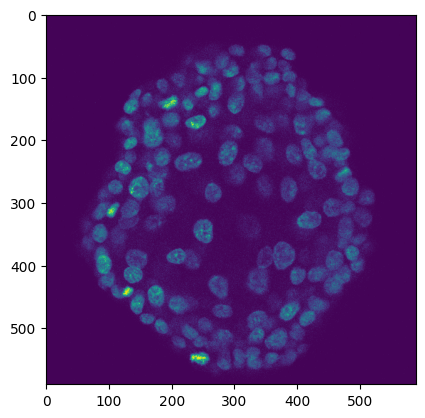

In [2]:
image = "https://github.com/StRigaud/pyopencl_clahe/raw/refs/heads/main/Test_image/TOrg2%20DAPI-1.tif"
raw = imread(image)
plt.imshow(raw[12])
plt.show()

## CLAHE doc and usage

In [6]:
cle.clahe?

Signature:
cle.clahe(
    input_image: Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array],
    output_image: Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array, NoneType] = None,
    tile_size: int = 8,
    clip_limit: float = 0.01,
    min_intensity: Optional[float] = nan,
    max_intensity: Optional[float] = nan,
    device: Optional[pyclesperanto._pyclesperanto._Device] = None,
) -> Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array]
Docstring:
Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to the input
image. The algorithm is adapted from the work of Hugo Raveton
(https://github.com/HugoRaveton/pyopencl_clahe)

Parameters
----------
input_image: Image
    Input image to process.
output_image: Optional[Image] (= None)
    Output result image.
tile_size: int (= 8)
    Size of the tiles to be used for CLAHE.
clip_limit: float (= 0.01)
    Clip limit for CLAHE.
min_intensity: Optional[float] (= None)
    Minimum intensity value.
max_intensity: Optio

In [4]:
results_gpu = cle.clahe(raw, tile_size=8, clip_limit=0.01)

### Let's compare the output

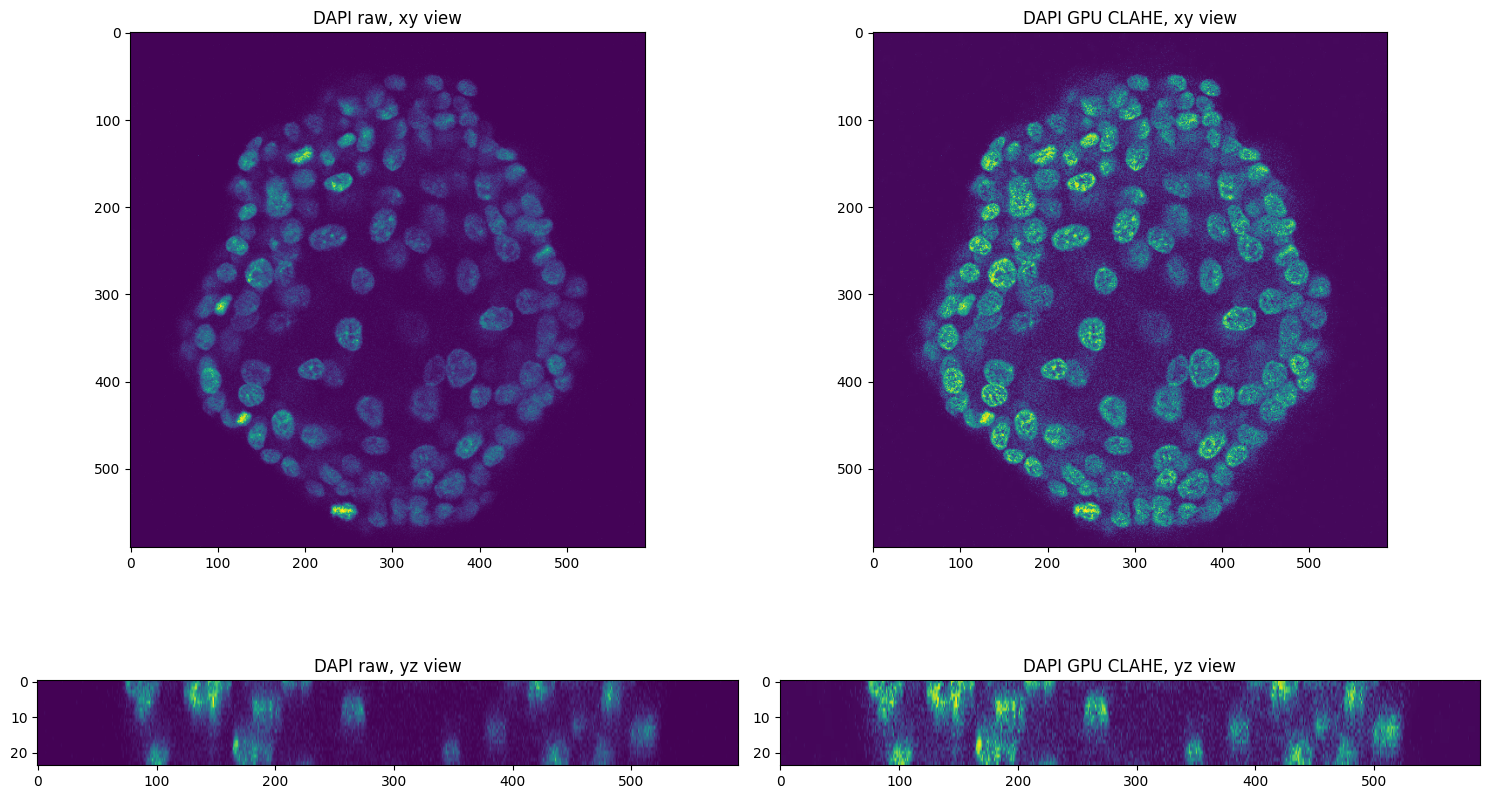

In [5]:
halfz = int(np.shape(raw)[0]/2)
halfx = int(np.shape(raw)[2]/2)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0][0].imshow(raw[halfz], cmap="viridis")
axs[0][1].imshow(results_gpu[halfz], cmap="viridis")
axs[1][0].imshow(raw[:,halfx,:], aspect = 3, cmap="viridis")
axs[1][1].imshow(results_gpu[:,halfx,:], aspect = 3, cmap="viridis")
axs[0][0].set_title('DAPI raw, xy view')
axs[0][1].set_title('DAPI GPU CLAHE, xy view')
axs[1][0].set_title('DAPI raw, yz view')
axs[1][1].set_title('DAPI GPU CLAHE, yz view')
plt.tight_layout()
plt.show()

Thanks for following this demos of CLAHE !